In [1]:
from pymultiwii import MultiWii
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter, JulierSigmaPoints, UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy.signal import lfilter

In [2]:
serialPort = "/dev/ttyACM0"
board = MultiWii(serialPort)

Waking up board on /dev/ttyACM0...
1


In [6]:
df_altitude = pd.DataFrame(columns=board.altitude.keys())
df_attitude = pd.DataFrame(columns=board.attitude.keys())
df_rcChannels = pd.DataFrame(columns=board.rcChannels.keys())
df_rawIMU = pd.DataFrame(columns=board.rawIMU.keys())
df_vtxConfig = pd.DataFrame(columns=board.vtxConfig.keys())

In [7]:
def concat_data(df, cmd: int):
    data = board.getData(cmd)
    return pd.concat([df,  pd.DataFrame(data, index=[0])], ignore_index=True)

for i in range(10000):    
    print(board.getData(MultiWii.ALTITUDE))
    # df_altitude = concat_data(df_altitude, MultiWii.ALTITUDE)
    # df_attitude = concat_data(df_attitude, MultiWii.ATTITUDE)
    # df_rcChannels = concat_data(df_rcChannels, MultiWii.RC)
    # df_rawIMU = concat_data(df_rawIMU, MultiWii.RAW_IMU)
    # df_vtxConfig = concat_data(df_vtxConfig, MultiWii.VTX_CONFIG)

{'estalt': -49.0, 'vario': -1.0, 'elapsed': 0.006, 'timestamp': '1682251510.09'}
{'estalt': -108.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.11'}
{'estalt': -108.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.13'}
{'estalt': -133.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.14'}
{'estalt': -133.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.16'}
{'estalt': -108.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.17'}
{'estalt': -74.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.19'}
{'estalt': -74.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.21'}
{'estalt': -91.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.22'}
{'estalt': -57.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.24'}
{'estalt': -57.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.25'}
{'estalt': -57.0, 'vario': -1.0, 'elapsed': 0.016, 'timestamp': '1682251510.27'}
{'estalt': -23.0, 'vari

In [14]:
df_altitude.to_csv("df_altitude.csv")
df_attitude.to_csv("df_attitude.csv")
df_rcChannels.to_csv("df_rcChannels.csv")
df_rawIMU.to_csv("df_rawIMU.csv")
df_vtxConfig.to_csv("df_vtxConfig.csv")

In [13]:
df_altitude.shape, df_attitude.shape, df_rcChannels.shape, df_rawIMU.shape, df_vtxConfig.shape

((10000, 4), (10000, 5), (10000, 6), (10000, 11), (10000, 6))

In [6]:
df = df.dropna()
# df = df.astype(int)

In [ ]:
filter = KalmanFilter(dim_x=2,      # Размер вектора стостояния
                    dim_z=1)      # Размер вектора измерений

processNoise = 1e-4
dt = 0.01

# F - матрица процесса - размер dim_x на dim_x - 2х2
filter.F = np.array([ [1,   dt],
                     [0,   1.0]])



# Матрица наблюдения - dim_z на dim_x - 1x2
filter.H = np.array([[1.0, 0.0]])

# filter.Q = [[dt**2,       dt],
#            [   dt,      1.0]] * processNoise

filter.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=0.13)

# Начальное состояние.
filter.x = np.array([0.0, 0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[8.0, 0.0],
                    [0.0, 8.0]])

In [35]:
dt = 0.1                       # Шаг времени
measurementSigma = 0.5          # Среднеквадратичное отклонение датчика
processNoise = 1e-4             # Погрешность модели

filter = KalmanFilter(dim_x=4,      # Размер вектора стостояния
                        dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 2х2
filter.F = np.array([ [1,  0,  dt, 0],
                     [0,   1.0, 0, dt],
                     [0.0, 0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0, 1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x2
filter.H = np.array([[1.0, 0.0, 0.0, 0.0]])
# filter.H = np.array([[1.0, 0.0, 0.0, 0.0]])

# filter.Q = np.array([[dt**2,       dt],
#            [   dt,      1.0]]) * processNoise

filter.Q = Q_discrete_white_noise(dim=4, dt=dt, var=processNoise)

# Начальное состояние.
filter.x = np.array([0.0, 0.0, 30.0, 10.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[1, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0],
                    [0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 1.0]])

In [36]:
filteredState = []
stateCovarianceHistory = []

for i in range(0, df.shape[0]):
   z = df.iloc[0]["estalt"]                    # Вектор измерений
   filter.predict()                            # Этап предсказания
   filter.update(z)                            # Этап коррекции

   filteredState.append(filter.x)
   stateCovarianceHistory.append(filter.P)


filteredState = np.array(filteredState)
stateCovarianceHistory = np.array(stateCovarianceHistory)

In [37]:
filteredState.shape

(995, 4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


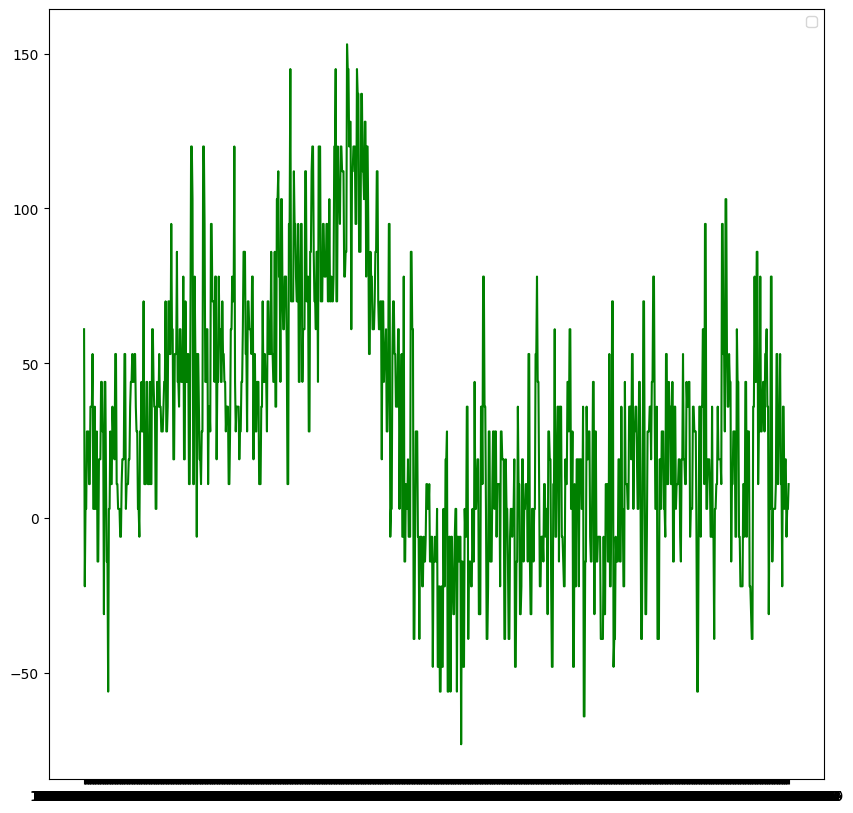

In [39]:
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(df["timestamp"], df["estalt"], color="green")
# plt.plot(df["timestamp"], filteredState[:, 1], label="Оценка фильтра, 1", color="blue")
# plt.plot(df["timestamp"], filteredState[:, 0], label="Оценка фильтра, 0", color="red")
# plt.plot(df["timestamp"], filteredState[:, 2], label="Оценка фильтра, 2", color="yellow")
# plt.plot(df["timestamp"], filteredState[:, 3], label="Оценка фильтра, 3", color="pink")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 10), dpi=100)

n = 100  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
# x, y = df["timestamp"], df["estalt"]
yy = lfilter(b, a, df["estalt"])
# plt.plot(df["timestamp"], df["estalt"], color="green")
# plt.plot(x, yy, linewidth=2, linestyle="-", c="b")  # smooth by filter
plt.plot(df["timestamp"], df["estalt"], color="green")
plt.plot(df["timestamp"], yy, label="Оценка фильтра", color="red")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(df["timestamp"], df["ax"], color="green")
plt.plot(df["timestamp"], df["ay"], color="red")
plt.plot(df["timestamp"], df["az"], color="blue")
plt.show()

In [ ]:
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(df["timestamp"], df["gx"], color="green")
plt.plot(df["timestamp"], df["gy"], color="red")
plt.plot(df["timestamp"], df["gz"], color="blue")
plt.show()

In [ ]:
df.info()